# Natural Language Inference using Neural Networks
Adam Ek

----------------------------------

The lab is an exploration and learning exercise to be done in a group and also in discussion with the teachers and other students.

Before starting, please read the instructions on [how to work on group assignments](https://github.com/sdobnik/computational-semantics/blob/master/README.md).

Write all your answers and the code in the appropriate boxes below.

----------------------------------

In this lab we'll work with neural networks for natural language inference. Our task is: given a premise sentence P and hypothesis H, what entailment relationship holds between them? Is H entailed by P, contradicted by P or neutral towards P?

Given a sentence P, if H definitely describe something true given P then it is an **entailment**. If H describe something that's *maybe* true given P, it's **neutral**, and if H describe something that's definitely *false* given P it's a **contradiction**. 

# 1. Data

We will explore natural language inference using neural networks on the SNLI dataset, described in [1]. The dataset can be downloaded [here](https://nlp.stanford.edu/projects/snli/). We prepared a "simplified" version, with only the relevant columns [here](https://gubox.box.com/s/idd9b9cfbks4dnhznps0gjgbnrzsvfs4).

The (simplified) data is organized as follows (tab-separated values):
* Column 1: Premise
* Column 2: Hypothesis
* Column 3: Relation

Like in the previous lab, we'll use torchtext to build a dataloader. You can essentially do the same thing as you did in the last lab, but with our new dataset. **[1 mark]**

In [1]:
import torch
import torch.nn as nn
from torchtext.data import Field, BucketIterator, TabularDataset
device = torch.device('cuda:0')

In [2]:
def dataloader(path_to_snli, batch_size=8):
    
    #Fields: premise sent, hypothesis sent, relation label
    Tokens = Field(tokenize=lambda x:x.split(), lower=True, batch_first=True) #TODO lowercase?
    Labels = Field(batch_first=True)
    
    fields = [('premise',Tokens),('hypothesis',Tokens),('label',Labels)]
    
    #Process from csv files
    train,test = TabularDataset.splits(
            path=path_to_snli, train='simple_snli_1.0_train.csv', test='simple_snli_1.0_test.csv',
            format='csv', fields=fields, skip_header=False, 
            csv_reader_params = {'delimiter':'\t','quotechar':'、'})
    
    #Build vocab
    Labels.build_vocab(train) # nr of classes
    Tokens.build_vocab(train)

    #Batch iterator
    train_iter, test_iter = BucketIterator.splits(
            (train,test), batch_size=batch_size, shuffle=True, device=device,
             sort_within_batch=True, sort_key=lambda x: len(x.premise)+len(x.hypothesis))
    
    return train_iter, test_iter, Tokens.vocab, Labels.vocab


In [3]:
train_iter, test_iter, vocab, labels = dataloader('simple-snli')

In [4]:
[labels.itos[i] for i in range(len(labels))]  # most golds & predictions should be indexed 2~4

['<unk>', '<pad>', 'entailment', 'contradiction', 'neutral', '-']

# 2. Model

In this part, we'll build the model for predicting the relationship between H and P.

We will process each sentence using an LSTM. Then, we will construct some representation of the sentence. When we have a representation for H and P, we will combine them into one vector which we can use to predict the relationship.

We will train a model described in [2], the BiLSTM with max-pooling model. The procedure for the model is roughly:

    1) Encode the Hypothesis and the Premise using one shared bidirectional LSTM (or two different LSTMS)
    2) Perform max over the tokens in the premise and the hypothesis
    3) Combine the encoded premise and encoded hypothesis into one representation
    4) Predict the relationship 

### Creating a representation of a sentence

Let's first consider step 2 where we perform max/mean pooling. There is a function in pytorch for this, but we'll implement it from scratch. 

Let's consider the general case, what we want to do for these methods is apply some function $f$ along dimension $i$, and we want to do this for all $i$'s. As an example we consider the matrix S with size ``(N, D)`` where N is the number of words and D the number of dimensions:

$S = \begin{bmatrix}
    s_{11} & s_{12} & s_{13} & \dots  & s_{1d} \\
    s_{21} & s_{22} & s_{23} & \dots  & s_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    s_{n1} & s_{n2} & s_{n3} & \dots  & s_{nd}
\end{bmatrix}$

What we want to do is apply our function $f$ on each dimension, taking the input $s_{1d}, s_{2d}, ..., s_{nd}$ and generating the output $x_d$. 

You will implement both the max pooling method. When performing max-pooling, $max$ will be the function which selects a _maximum_ value from a vector and $x$ is the output, thus for each dimension $d$ in our output $x$ we get:

\begin{equation}
    x_d = max(s_{1d}, s_{2d}, ..., s_{nd})
\end{equation}


This operation will reduce a batch of size ``(batch_size, num_words, dimensions)`` to ``(batch_size, dimensions)`` meaning that we now have created a sentence representation based on the content of the words representations in the sentence. 

Create a function that takes as input a tensor of size ``(batch_size, num_words, dimensions)`` then performs max pooling and returns the result (the output should be of size: ```(batch_size, dimensions)```). [**4 Marks**]

In [3]:
import numpy as np

def pooling(input_tensor):
    
    # input tensor: BxNxD 
    # reduce dim1 to max(N) => Bx1xD
    # 1) PT build-in way
#     output_tensor, idxs = torch.max( input_tensor, dim=1) 
#     return output_tensor

#     B,N,D = input_tensor.shape
    
    # 2)native python max:
#     output_tensor = [ [max(input_tensor[b, :, d]) for d in range(D)] for b in range(B) ]
    
    # 3)convert to numpy array:
#     output_tensor = [ [input_tensor[b,:,d].numpy().max() for d in range(D)] for b in range(B) ]
    array = input_tensor.numpy()
    output_tensor = np.amax(array, axis=1)
    
    # 4) Use torch.argmax
#     get_max = lambda vector : vector[ torch.argmax(vector) ]
#     output_tensor = [ [get_max(input_tensor[b,:,d]) for d in range(D)] for b in range(B) ]
    
    return torch.tensor(output_tensor) #BxD

def pt_pooling(input_tensor):
    # PyTorch buildin method
    output_tensor, idxs = torch.max( input_tensor, dim=1) 
    return output_tensor

# test_tens = torch.stack( [torch.tensor([[1,1,1,1],[2,2,2,2],[3,3,3,3]])]*10000, dim=0)
test_tens = torch.randint(1000, (512, 64, 128)) # BxNxD
# print(test_tens)

import time
start_time = time.time()
first = pt_pooling(test_tens)
print("torch.max() took %s seconds" % (time.time() - start_time))
# print(first)

start_time = time.time()
second = pooling(test_tens) #😰 It's much slower
print("pooling() took %s seconds" % (time.time() - start_time))
# print(second)

torch.eq(first, second).all()

torch.max() took 0.0067331790924072266 seconds
pooling() took 0.013793706893920898 seconds


tensor(True)

### Combining sentence representations

Next, we need to combine the premise and hypothesis into one representation. We will do this by concatenating four tensors (the final size of our tensor $X$ should be ``(batch_size, 4d)`` where ``d`` is the number of dimensions that you use): 

$$X = [P; H; |P-H|; P \cdot H]$$

Here, what we do is concatenating P, H, P times H, and the absolute value of P minus H, then return the result.

Implement the function. **[2 marks]**

In [4]:
def combine_premise_and_hypothesis(premise, hypothesis):
    
    #input: BxD, BxD
    p,h = premise, hypothesis
    elements = [p, h, abs(p-h), p*h] # BxD, BxD, BxD, BxD

    output = torch.cat(elements, dim=1) # Concat vectors in dim1 (skip dim0, ie batchsize)
    
    return output # Bx(D*4)

In [5]:
one = torch.tensor( [[1,2,3]]*5 )
two = torch.tensor( [[4,5,6]]*5 )

combine_premise_and_hypothesis(one, two)

tensor([[ 1,  2,  3,  4,  5,  6,  3,  3,  3,  4, 10, 18],
        [ 1,  2,  3,  4,  5,  6,  3,  3,  3,  4, 10, 18],
        [ 1,  2,  3,  4,  5,  6,  3,  3,  3,  4, 10, 18],
        [ 1,  2,  3,  4,  5,  6,  3,  3,  3,  4, 10, 18],
        [ 1,  2,  3,  4,  5,  6,  3,  3,  3,  4, 10, 18]])

### Creating the model

Finally, we can build the model according to the procedure given previously by using the functions we defined above. Additionaly, in the model you should use *dropout*. For efficiency purposes, it's acceptable to only train the model with either max or mean pooling. 

Implement the model [**6 marks**]

In [19]:
class SNLIModel(nn.Module):
    def __init__(self, vocab_dim, num_labels, h_dim):
        super(SNLIModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_dim, h_dim)
        self.rnn = nn.LSTM(h_dim, h_dim, batch_first=True, bidirectional=True )
        self.classifier = nn.Linear(8*h_dim, num_labels) 
        self.dropout = nn.Dropout(0.2) 
        
    def forward(self, premise, hypothesis):
       #1)Encode the Hypothesis and the Premise using one shared bidirectional LSTM
        #Embed premise & hypothesis sentences
        p, h = self.embeddings(premise), self.embeddings(hypothesis) #BxNxD
        
        #Encode through BiLSTM
        p,(_, _) = self.rnn(p)# BxNxHD*2
        h,(_, _) = self.rnn(h)
        p, h = self.dropout(p), self.dropout(h)
        
       #2)Perform max over the tokens in the premise and the hypothesis
        # Max pool the embeddings
        # 🙄 we use torch.max here for efficiency reasons cuz the Python way is very slow compared to C++
        p_pooled, h_pooled = pt_pooling(p), pt_pooling(h) #BxNxHD*2 => BxHD*2
       
       #3)Combine the encoded premise and encoded hypothesis into one representation
        ph_representation = combine_premise_and_hypothesis(p_pooled, h_pooled) #BxD => B x HD*2*4
#         ph_representation = self.dropout(ph_representation)
        
       #4)Predict the relationship 
        predictions = self.classifier(ph_representation)
        
        return predictions

# 3. Training and testing

As before, implement the training and testing of the model. SNLI can take a very long time to train, so I suggest you only run it for one or two epochs. **[2 marks]** 

**Tip for efficiency:** *when developing your model, try training and testing the model on one batch (for each epoch) of data to make sure everything works! It's very annoying if you train for N epochs to find out that something went wrong when testing the model, or to find that something goes wrong when moving from epoch 0 to epoch 1.*

In [7]:
# Load datasets
train_iter, test_iter, vocab, labels = dataloader('simple-snli', batch_size=512)

In [20]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [21]:
epochs,learning_rate = 3, 0.001

snli_model = SNLIModel( len(vocab), len(labels), 384)
snli_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snli_model.parameters(), lr=learning_rate)

#Training model
print('Training model...')
from statistics import mean
total_loss = [] 
for _ in range(epochs):
    
    total_loss.clear()
    
    for i, batch in enumerate(train_iter):
        
        premise, hypothesis = batch.premise, batch.hypothesis
        label = batch.label  # gold labels of batch
        
        output = snli_model(premise, hypothesis)
        
#         print(premise.shape) #BxN
#         print(output.view(-1,len(labels)).shape) #BxL
#         print(label.view(-1).shape) #Bx1
#         break
        
        loss = loss_function(output, label.view(-1)) # modelout:BxL, target:B
        total_loss += [loss.item()]

        print(f'Average total loss: {mean(total_loss)}', end='\r')
        
        # compute gradients; # update parameters; # reset gradients
        loss.backward();     optimizer.step();    optimizer.zero_grad()
    
    print()
#     break

Training model...
Average total loss: 0.7526697769275932
Average total loss: 0.5959363676780878
Average total loss: 0.50962367404338935


In [22]:
# Test with test_iter
test_loss = []
snli_model.eval()
for i, batch in enumerate(test_iter):
    
    premise, hypothesis = batch.premise, batch.hypothesis
    label = batch.label  # gold labels of batch

    with torch.no_grad(): # dont collect gradients when testing
        output = snli_model(premise, hypothesis)
    batch_loss = loss_function(output, label.view(-1))
    test_loss += [batch_loss.item()]

    print('Average test loss:', mean(test_loss), '  Tested on :', len(test_loss)*len(batch), end='\r')

In [23]:
# Save:
torch.save(snli_model.state_dict(), 'snli_model.pt')

# Load:
# vocabsize, num_labels, h_dim = len(vocab),len(labels),32  

# snli_model = SNLIModel(vocab_dim, num_labels, h_dim)
# snli_model.load_state_dict(torch.load('snli_model.pt'), )
# snli_model.eval()

In [24]:
confusion = {'Golds':[], 'Predicted': []}
results=[]

for i, batch in enumerate(test_iter):
    
    premise, hypothesis = batch.premise, batch.hypothesis
    label = batch.label  # gold labels of batch
    
    with torch.no_grad(): # dont collect gradients when testing
        output = snli_model(premise, hypothesis)
        
    for b in range( len(batch) ):
        
        goldlabel = labels.itos[label[b]]
        prediction = labels.itos[ torch.argmax(output[b]) ]
        
        results.append( int(goldlabel==prediction) )
        confusion['Golds'].append(goldlabel)
        confusion['Predicted'].append(prediction)
        
import pandas as pd
df = pd.DataFrame(confusion, columns=['Golds','Predicted'])
matrix = pd.crosstab(df['Golds'], df['Predicted'], rownames=['Golds'], colnames=['Predicted'])
print( 'Accuracy:', mean(results) )
matrix

Accuracy: 0.7521


Predicted,contradiction,entailment,neutral
Golds,,,
-,48,62,66
contradiction,2716,176,345
entailment,377,2523,468
neutral,606,331,2282


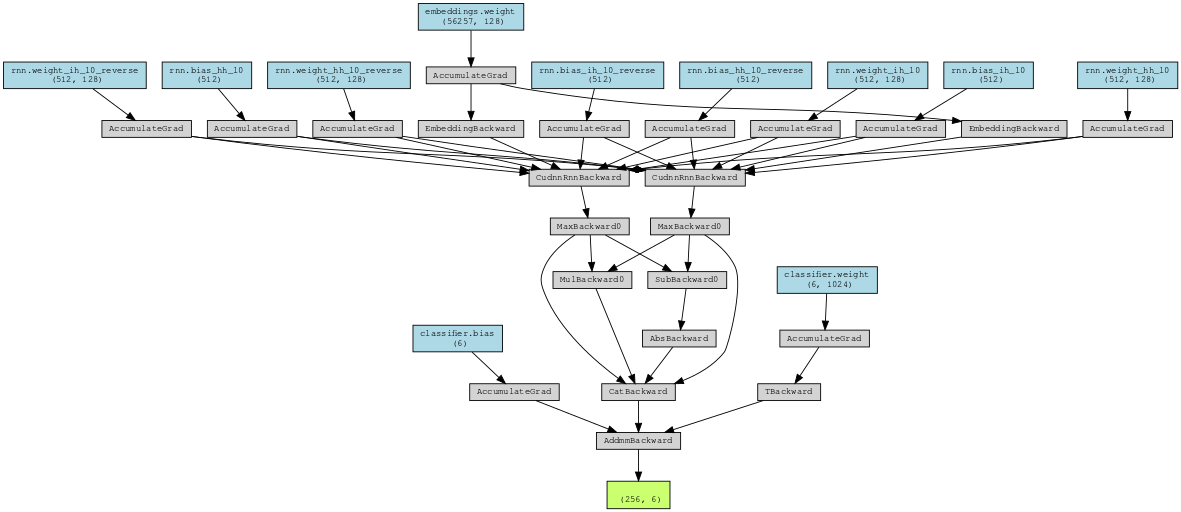

In [60]:
# from torchviz import make_dot
# dummybat=next(iter(train_iter))
# m = snli_model(dummybat.premise, dummybat.hypothesis)
# make_dot(m, params=dict(list(snli_model.named_parameters()))).render('snli_model', format='png')
# from IPython import display
# display.Image("snli_model.png")

Suggest a _baseline_ that we can compare our model against **[2 marks]**

    **Your answer should go here**
    :)

Suggest some ways (other than using a baseline) in which we can analyse the models performance **[4 marks]**.

**Ans:**
Apply the model on the training data to evaluation the accuracy.



Suggest some ways to improve the model **[3 marks]**.

**Your answer should go here**

In our model, we max-pooled the premise and hypothesis separately before combining them. Thus some information may be filtered out before the combination. Maybe switching the order of max pooling and combination can let us get the interaction of the two vectors first before extracting/filtering by pooling. Alternatively, we can apply the method mentioned in Talman et al (2019) by feeding the layers both the pooled output from the previous layer as well as the original input, so the information doesn't get too diluted in the deeper layers.

Also, Bowman et al (2015) mentioned the importance of syntactic structures of sentences when determining the relationships between premise and hypothesis. 
We think this aligns with how humans judge the premise vs hypthesis: we would picture/imagine what the sentences describe and decide whether one entails or contradict the other, instead of just comparing the texts themselves (it would be like someone who doesn't understand English but reads Latin script studying our dataset and eventually works out a pattern for classification, despite not understanding the sentence meanings).

Therefore, it may be useful to parse the raw sentences into syntax trees first before embedding to help establishing the relations of roles described in a sentence. This is done in the SNLI 1.0 datasets in the `sentence_binary_parse` and `sentence_parse` columns. It will be interesting to compare the performance of training with raw sentence vs training with parsed trees.

Another way is to use pre-trained model and tokenizer, eg BERT to for the embeddings because interpreting the inference of premise->hypothesis requires world knowledge especially when determining the hierarchical relationships of things (eg, a rabbit is an animal but not vice versa).

### Readings

[1] Samuel R. Bowman, Gabor Angeli, Christopher Potts, and Christopher D. Manning. 2015. A large annotated corpus for learning natural language inference. In Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing (EMNLP). 

[2] Conneau, A., Kiela, D., Schwenk, H., Barrault, L., & Bordes, A. (2017). Supervised learning of universal sentence representations from natural language inference data. arXiv preprint arXiv:1705.02364.